# Thermal-Shock Fracture

In [ ]:
# [collapse: code] Colab Setup (Install Dependencies)

# Only run this if we are in Google Colab
if 'google.colab' in str(get_ipython()):
    print("Installing dependencies from pyproject.toml...")
    # This installs the repo itself (and its dependencies)
    !apt-get install gmsh 
    !apt-get install -qq xvfb libgl1-mesa-glx
    !pip install pyvista -qq
    !pip install -q "git+https://github.com/smec-ethz/tatva-docs.git"    
    print("Installation complete!")



In this example, we demonstrate the power of the energy-centric approach by simulating a complex multiphysics problem: **Thermal Shock Fracture** where we will use **Phase-field** approach to simulate fracture process.

A hot ceramic plate ($T_{initial} = 500^\circ C$) is suddenly submerged in a cold bath ($T_{boundary} = 0^\circ C$) . The rapid cooling creates tensile stresses on the surface, causing cracks to initiate and propagate inward.

**The Physics (3-Way Coupling):**

-  **Thermal:** Heat diffusion (potentially degraded by cracks).
-  **Mechanical:** Thermal contraction creates stress; Stiffness is degraded by damage.
-  **Phase-Field:** Damage evolves to minimize the stored elastic energy and surface energy.
 
The total energy functional is:
 
$$
 \Psi(u, T, d) = \Psi_\text{elastic}(u, T, d) + \Psi_\text{fracture}(d) + \Psi_\text{thermal}(T, d)
$$

 
Where the elastic energy is degraded by the damage variable $d$:
 
$$
\Psi_\text{elastic} = \int_\Omega \left( (1-d)^2 + \eta \right) \Psi^+_0(\boldsymbol{\epsilon}) \, d\Omega
$$ 

And the fracture energy follows the standard `AT2` regularization:
 
$$
\Psi_\text{fracture} = G_c \int_\Omega \left( \frac{d^2}{2l_0} + \frac{l_0}{2} |\nabla d|^2 \right) \, d\Omega
$$ 

 This complex coupling is handled automatically by the Tatva engine.


In [ ]:
import jax

jax.config.update("jax_enable_x64", True)

from typing import NamedTuple

import equinox as eqx
import gmsh
import jax.numpy as jnp
import matplotlib.pyplot as plt
import meshio
import numpy as np
from jax import Array
from jax_autovmap import autovmap
from tatva import Mesh, Operator, element



## Model Setup
We generate a fine, uniform mesh for a rectangular ceramic strip. The mesh size must be smaller than the phase field length scale $l_0$.



In [ ]:
# [collapse: code] Generate a strip mesh using gmsh

def generate_strip_mesh(width: float, height: float, mesh_size: float):
    import os

    mesh_dir = os.path.join(os.getcwd(), "../meshes")
    os.makedirs(mesh_dir, exist_ok=True)
    output_filename = os.path.join(mesh_dir, "strip_fine.msh")

    gmsh.initialize()
    gmsh.model.add("strip")

    p1 = gmsh.model.geo.addPoint(0, 0, 0, mesh_size)
    p2 = gmsh.model.geo.addPoint(width, 0, 0, mesh_size)
    p3 = gmsh.model.geo.addPoint(width, height, 0, mesh_size)
    p4 = gmsh.model.geo.addPoint(0, height, 0, mesh_size)

    l1 = gmsh.model.geo.addLine(p1, p2)
    l2 = gmsh.model.geo.addLine(p2, p3)
    l3 = gmsh.model.geo.addLine(p3, p4)
    l4 = gmsh.model.geo.addLine(p4, p1)

    loop = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4])
    surface = gmsh.model.geo.addPlaneSurface([loop])

    gmsh.model.geo.synchronize()
    gmsh.model.addPhysicalGroup(2, [surface], 1, name="domain")

    # Boundary groups
    gmsh.model.addPhysicalGroup(1, [l1, l2, l3, l4], 2, name="boundaries")

    gmsh.model.mesh.generate(2)
    gmsh.write(output_filename)
    gmsh.finalize()

    _mesh = meshio.read(output_filename)
    mesh = Mesh(coords=_mesh.points[:, :2], elements=_mesh.cells_dict["triangle"])
    return mesh


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000743599s, CPU 0.000928s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.891818s, CPU 0.880898s)
Info    : 29077 nodes 58156 elements
Info    : Writing '/home/pundir/Documents/research-notes/tatva-examples/examples/../meshes/strip_fine.msh'...
Info    : Done writing '/home/pundir/Documents/research-notes/tatva-examples/examples/../meshes/strip_fine.msh'

Number of nodes: 29077


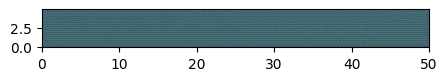

In [3]:
L = 50  # Length mm
H = 4.9  # Height mm
l0 = 0.2  # 0.2 # Length scale parameter
h_mesh = l0 / 2.0  # Mesh size must be approx l0/2

mesh = generate_strip_mesh(width=L, height=H, mesh_size=h_mesh)
n_nodes = mesh.coords.shape[0]
print(f"Number of nodes: {n_nodes}")

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.tripcolor(
    *mesh.coords.T,
    mesh.elements,
    facecolors=jnp.zeros(mesh.elements.shape[0]),
    edgecolors="k",
    lw=0.1,
    cmap="managua_r",
)

ax.axhline(0, color="k", lw=0.4)
ax.set_aspect("equal")
ax.margins(0.0, 0.0)
plt.show()

In [4]:
class Material(NamedTuple):
    E: float = 340e3  # Young's modulus (N/mm2)
    nu: float = 0.2  # Poisson's ratio
    alpha: float = 8e-6  # Thermal expansion (1/K)
    kappa: float = 300  # Thermal conductivity
    Gc: float = 0.042  # Critical energy release rate (Fracture toughness N/m)
    l0: float = l0  # Phase field length scale


mat = Material()
mu = mat.E / (2 * (1 + mat.nu))
lmbda = mat.E * mat.nu / ((1 + mat.nu) * (1 - 2 * mat.nu))

## Energy Functionals
 
This is the core of the energy-centric approach. We define densities for **Elasticity**, **Thermal**, and **Fracture**.
 
### Coupled Elastic Energy
Strain energy is driven by thermal contraction and degraded by damage:

$$ 
\psi_{el} = ((1-d)^2 + \eta) \cdot \frac{1}{2} \boldsymbol{\epsilon}_{el} : \mathbb{C} : \boldsymbol{\epsilon}_{el} 
$$

where $\boldsymbol{\epsilon}_{el} = \boldsymbol{\epsilon}_{total} - \alpha \Delta T \mathbf{I}$.


In [5]:
@autovmap(eps=2, mu=0, lmbda=0)
def compute_stress(eps: Array, mu: float, lmbda: float) -> Array:
    """Compute the stress tensor from the strain tensor."""
    I = jnp.eye(2)
    return 2 * mu * eps + lmbda * jnp.trace(eps) * I


@autovmap(eps=2, mu=0, lmbda=0)
def strain_energy(eps: Array, mu: float, lmbda: float) -> Array:
    """Compute the strain energy density."""
    sig = compute_stress(eps, mu, lmbda)
    return 0.5 * jnp.einsum("ij,ij->", sig, eps)


@autovmap(grad_u=2, theta_quad=0, mu=0, lmbda=0, alpha=0)
def compute_elastic_energy_density(
    grad_u: Array, theta_quad: Array, mu: float, lmbda: float, alpha: float
) -> Array:
    """Computes the tensile part of the strain energy (driven by thermal contraction)."""

    # Total Strain
    eps_total = 0.5 * (grad_u + grad_u.T)

    # Thermal Strain (Isotropic expansion/contraction)
    eps_thermal = alpha * theta_quad * jnp.eye(2)

    # Elastic Strain
    eps_el = eps_total - eps_thermal

    tr_eps = jnp.trace(eps_el)
    tr_plus = jnp.maximum(tr_eps, 0.0)  # macalay_bracket_plus(tr_eps)
    tr_minus = jnp.minimum(tr_eps, 0.0)  # macalay_bracket_minus(tr_eps)

    # Volumetric/deviatoric split
    dim = eps_el.shape[0]
    eps_vol = (tr_eps / dim) * jnp.eye(2)
    eps_dev = eps_el - eps_vol

    K = lmbda + 2 * mu / dim  # Bulk modulus

    # Volumetric and deviatoric strain energy densities
    psi_vol = 0.5 * K * tr_plus**2 + mu * jnp.einsum("ij,ij->", eps_dev, eps_dev)
    psi_dev = 0.5 * K * tr_minus**2

    return psi_vol, psi_dev


### Fracture Energy (Phase Field)
The geometric resistance to cracking.

$$
 \underbrace{\int_\Omega \Gamma \left[ \frac{(d-1)^2}{2l_0} + \frac{l_0}{2} |\nabla d|^2 \right] ~ \mathrm{d\Omega}}_{\text{Fracture Surface Energy}}
$$

We employ a "History Field" strategy. Damage is irreversible; it should only grow. A common way to handle this in phase-field is to drive damage by the *maximum historical strain energy* ($\mathcal{H}$).
 
$$ \Psi_d = \int_\Omega \left( [(1-d)^2 + \eta] \mathcal{H} + \psi_{frac} \right) d\Omega $$


In [6]:
@autovmap(d=0)
def degradation_function(d: Array) -> Array:
    """Degradation function g(d) = (1-d)^2 + small_residual"""
    return (1.0 - d) ** 2 + 1e-6


@autovmap(d=0, grad_d=1, Gc=0, l0=0)
def fracture_energy_density(d: Array, grad_d: Array, Gc: float, l0: float) -> Array:
    """Griffith energy approximation."""
    w_d = (d**2) / (2 * l0)
    w_grad = (l0 / 2.0) * jnp.dot(grad_d, grad_d)
    return Gc * (w_d + w_grad)

### Thermal Problem (Simple Transient Heat Equation)

We treat Thermal as a simple linear step for this demo (Backward Euler)

$$
\underbrace{\int_\Omega \frac{1}{2}\Delta t (T^{t}-T^{t-1})^2~\mathrm{d\Omega} + \int_\Omega \kappa \nabla T\cdot\nabla T~\mathrm{d\Omega}}_{\text{Transient Heat Potential}, \Psi_{\mathrm{th}}}
$$

In [7]:
@autovmap(grad_theta=1, kappa=0)
def thermal_energy_density(grad_theta: Array, kappa: float) -> Array:
    """compute_thermal energy_density

    Args:
        grad_theta (Array): gradient of temperature field
        kappa (float): thermal conductivity

    Returns:
        Array: thermal energy density
    """

    return 0.5 * kappa * jnp.einsum("i, i->", grad_theta, grad_theta)

## Total Energy for each physical process

We will now define the energy functional for each process. Since all the 3 process are happening int he same domain, we can define a sinle `Operator`.

In [8]:
tri = element.Tri3()
op = Operator(mesh, tri)

First, we start with defining the total potential for **thermal process**. Here we define the temporal evolution.

In [9]:
@jax.jit
def total_thermal_energy(theta_new, theta_old, dt):
    theta_new_quad = op.eval(theta_new)
    theta_old_quad = op.eval(theta_old)

    grad_theta = op.grad(theta_new)

    diff_term = thermal_energy_density(grad_theta, mat.kappa)

    inertial_term = (0.5 / dt) * (theta_new_quad - theta_old_quad) ** 2
    return op.integrate(diff_term + inertial_term)

Next, we define the **fracture** and **deformation** total energies under quasi-static assumption.

In [10]:
@jax.jit
def total_damage_energy(d_flat: Array, history_field_quad: Array) -> Array:
    """
    Minimizing this w.r.t 'd' solves the Phase Field evolution.
    Args:
        d_flat: Nodal damage values
        history_field_quad: Max historical strain energy at quadrature points
    """
    grad_d = op.grad(d_flat)
    d_quad = op.eval(d_flat)

    g_d = degradation_function(d_quad)

    strain_energy_comp = op.integrate(g_d * history_field_quad)

    fracture_dens = fracture_energy_density(d_quad, grad_d, mat.Gc, mat.l0)
    fracture_energy_comp = op.integrate(fracture_dens)

    return strain_energy_comp + fracture_energy_comp


@jax.jit
def total_strain_energy(
    u_flat: Array, theta_flat: Array, theta_ref: Array, d_flat: Array
) -> Array:
    """
    Minimizing this w.r.t 'u' solves Mechanical Equilibrium.
    """
    u = u_flat.reshape(-1, 2)
    grad_u = op.grad(u)
    theta_quad = op.eval(theta_flat)
    delta_theta = theta_quad - theta_ref
    d_quad = op.eval(d_flat)

    # Compute undegraded elastic energy density
    psi_plus, psi_minus = compute_elastic_energy_density(
        grad_u, delta_theta, mu, lmbda, mat.alpha
    )

    g_d = degradation_function(d_quad)

    return op.integrate(g_d * psi_plus + psi_minus)


## Matrix-Free Solvers Setup
We define our gradients (residuals) and tangent operators. Note the simplicity: we just ask `JAX` to differentiate the potentials. We use a projected conjugate gradient to apply the Diriechlet boundary conditions.


In [11]:
grad_thermal = jax.jacrev(total_thermal_energy, argnums=0)
grad_mechanical = jax.jacrev(total_strain_energy, argnums=0)
grad_damage = jax.jacrev(total_damage_energy, argnums=0)


@eqx.filter_jit
def compute_tangent(dx, u_prev, gradient, fixed_dofs):
    """Generic Tangent Vector Product for any physics"""
    dx_proj = dx.at[fixed_dofs].set(0)
    tangent = jax.jvp(gradient, (u_prev,), (dx_proj,))[1]
    return tangent.at[fixed_dofs].set(0)

In [ ]:
# [collapse: code] Newton-Krylov solver

@eqx.filter_jit
def conjugate_gradient(A, b, atol=1e-8, max_iter=100):
    iiter = 0

    def body_fun(state):
        b, p, r, rsold, x, iiter = state
        Ap = A(p)
        alpha = rsold / jnp.vdot(p, Ap)
        x = x + jnp.dot(alpha, p)
        r = r - jnp.dot(alpha, Ap)
        rsnew = jnp.vdot(r, r)
        p = r + (rsnew / rsold) * p
        rsold = rsnew
        iiter = iiter + 1
        return (b, p, r, rsold, x, iiter)

    def cond_fun(state):
        b, p, r, rsold, x, iiter = state
        return jnp.logical_and(jnp.sqrt(rsold) > atol, iiter < max_iter)

    x = jnp.full_like(b, fill_value=0.0)
    r = b - A(x)
    p = r
    rsold = jnp.vdot(r, p)

    b, p, r, rsold, x, iiter = jax.lax.while_loop(
        cond_fun, body_fun, (b, p, r, rsold, x, iiter)
    )
    return x, iiter


def newton_krylov_solver(
    u,
    fext,
    gradient,
    compute_tangent,
    fixed_dofs,
    tol: float = 1e-8,
):
    fint = gradient(u)

    iiter = 0
    norm_res = 1.0

    max_iter = 80

    while norm_res > tol and iiter < max_iter:
        residual = fext - fint
        residual = residual.at[fixed_dofs].set(0)
        A = eqx.Partial(
            compute_tangent, u_prev=u, gradient=gradient, fixed_dofs=fixed_dofs
        )
        du, cg_iiter = conjugate_gradient(A=A, b=residual, atol=1e-8, max_iter=1000)

        u = u.at[:].add(du)
        fint = gradient(u)
        residual = fext - fint
        residual = residual.at[fixed_dofs].set(0)
        norm_res = jnp.linalg.norm(residual)
        iiter += 1

        jax.debug.print(
            "  Newton Iteration {iiter}, Residual Norm: {norm_res:.3e}",
            iiter=iiter,
            norm_res=norm_res,
        )

    return u, norm_res

## Applying boundary conditions

In [13]:
x_min = jnp.min(mesh.coords[:, 0])
x_max = jnp.max(mesh.coords[:, 0])
y_min = jnp.min(mesh.coords[:, 1])
y_max = jnp.max(mesh.coords[:, 1])


eps_geo = 1e-5
bnd_nodes = jnp.where(
    (mesh.coords[:, 0] < eps_geo)
    | (mesh.coords[:, 0] > L - eps_geo)
    | (mesh.coords[:, 1] < eps_geo)
    | (mesh.coords[:, 1] > H - eps_geo)
)[0]


left_nodes = jnp.where(mesh.coords[:, 0] == x_min)[0]
bottom_nodes = jnp.where(mesh.coords[:, 1] == y_min)[0]
top_nodes = jnp.where(mesh.coords[:, 1] == y_max)[0]
right_nodes = jnp.where(mesh.coords[:, 0] == x_max)[0]

## Simulation Loop: The Staggered Solver
 
We implement a robust staggered scheme for **Thermal Shock**:

- **Initialize:** $T = 500$, $d = 0$.
- **Apply BC:** Boundary $T = 0$.
- **Time Loop:**
     * **Step A (Thermal):** Solve heat diffusion.
     * **Step B (Coupling):** Compute strain energy $\Psi_0(u, T)$ and update History $\mathcal{H} = \max(\mathcal{H}, \Psi_0)$.
     * **Step C (Phase Field):** Solve for $d$ using $\mathcal{H}$.
     * **Step D (Mechanical):** Solve for $u$ using new $T$ and $d$.


In [ ]:
# [output: hide] 

T_initial = 550.0  # K
u_sol = jnp.zeros(n_nodes * 2)
d_sol = jnp.zeros(n_nodes)
theta_sol = jnp.ones(n_nodes) * T_initial

fext_u = jnp.zeros_like(u_sol)
fext_d = jnp.zeros_like(d_sol)
fext_th = jnp.zeros_like(theta_sol)


fixed_dofs_th = jnp.concatenate([left_nodes, bottom_nodes])  # bnd_nodes
fixed_vals_th = jnp.full(len(fixed_dofs_th), 300)  # Cold bath

fixed_dofs_u = jnp.concatenate([2 * top_nodes + 1, 2 * right_nodes])
fixed_dofs_d = jnp.array([], dtype=int)

u_reshaped = u_sol.reshape(-1, 2)
grad_u = op.grad(u_reshaped)
theta_quad = op.eval(theta_sol)
theta_quad_ref = op.eval(theta_sol)

delta_theta = theta_quad - theta_quad_ref

psi_plus, psi_minus = compute_elastic_energy_density(
    grad_u, delta_theta, mu, lmbda, mat.alpha
)
history_field = psi_plus  # Start with initial elastic energy

dt = 1e-5
n_time_steps = 300

results_u = []
results_d = []
results_T = []

print(f"Starting Simulation with {n_nodes} nodes...")

for step in range(1, n_time_steps + 1):
    print(f"--- Time Step {step} ---")

    theta_sol = theta_sol.at[fixed_dofs_th].set(fixed_vals_th)

    grad_fn_th = eqx.Partial(grad_thermal, theta_old=theta_sol, dt=dt)
    theta_sol, norm_T = newton_krylov_solver(
        theta_sol,
        fext=fext_th,
        gradient=grad_fn_th,
        compute_tangent=compute_tangent,
        fixed_dofs=fixed_dofs_th,
        tol=1e-7,
    )

    for stag in range(1):
        u_reshaped = u_sol.reshape(-1, 2)
        grad_u = op.grad(u_reshaped)
        theta_quad = op.eval(theta_sol)
        delta_theta = theta_quad - theta_quad_ref

        psi_plus_current, psi_minus_current = compute_elastic_energy_density(
            grad_u, delta_theta, mu, lmbda, mat.alpha
        )

        history_field = jnp.maximum(history_field, psi_plus_current)

        # Solve Phase Field
        grad_fn_d = eqx.Partial(grad_damage, history_field_quad=history_field)
        d_sol, norm_d = newton_krylov_solver(
            d_sol,
            fext=fext_d,
            gradient=grad_fn_d,
            compute_tangent=compute_tangent,
            fixed_dofs=fixed_dofs_d,
        )

        # Solve Mechanical
        grad_fn_u = eqx.Partial(
            grad_mechanical,
            theta_flat=theta_sol,
            theta_ref=theta_quad_ref,
            d_flat=d_sol,
        )
        u_sol, norm_u = newton_krylov_solver(
            u_sol,
            fext=fext_u,
            gradient=grad_fn_u,
            compute_tangent=compute_tangent,
            fixed_dofs=fixed_dofs_u,
        )

        print(f"   Iter {stag}: Res_d={norm_d:.2e}, Res_u={norm_u:.2e}")

    results_u.append(u_sol)
    results_d.append(d_sol)
    results_T.append(theta_sol)


Starting Simulation with 29077 nodes...
--- Time Step 1 ---
  Newton Iteration 1, Residual Norm: 7.534e-09
  Newton Iteration 1, Residual Norm: 8.811e-09
  Newton Iteration 1, Residual Norm: 2.628e+00
  Newton Iteration 2, Residual Norm: 9.845e-02
  Newton Iteration 3, Residual Norm: 1.830e-04
  Newton Iteration 4, Residual Norm: 9.949e-09
   Iter 0: Res_d=8.81e-09, Res_u=9.95e-09
--- Time Step 2 ---
  Newton Iteration 1, Residual Norm: 9.717e-09
  Newton Iteration 1, Residual Norm: 7.276e-09
  Newton Iteration 1, Residual Norm: 2.461e+00
  Newton Iteration 2, Residual Norm: 6.174e-02
  Newton Iteration 3, Residual Norm: 1.400e-03
  Newton Iteration 4, Residual Norm: 9.950e-09
   Iter 0: Res_d=7.28e-09, Res_u=9.95e-09
--- Time Step 3 ---
  Newton Iteration 1, Residual Norm: 7.273e-09
  Newton Iteration 1, Residual Norm: 7.093e-09
  Newton Iteration 1, Residual Norm: 2.698e+00
  Newton Iteration 2, Residual Norm: 4.024e-02
  Newton Iteration 3, Residual Norm: 7.229e-08
  Newton Iteratio

## Visualization
We plot the results. Notice how the cracks (Field $d$) initiate at the boundaries where the thermal gradient (and thus tensile stress) is highest.

In [ ]:
# [collapse: code] Analtical solution for 1D transient heat conduction (for validation)

import matplotlib.patches as patches
import matplotlib.tri as tri_mat
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable


def set_size(fraction=1, height_ratio="golden", width="two-column", subplots=(1, 1)):
    if width == "two-column":
        width_pt = 180  # mm
    elif width == "one-column":
        width_pt = 90  # mm
    else:
        width_pt = width

    if height_ratio == "golden":
        ratio_pt = (np.sqrt(5) - 1.0) / 2.0
    else:
        ratio_pt = height_ratio

    fig_width_pt = width_pt * fraction
    inches_per_pt = 1.0 / 25.4
    fig_width_in = fig_width_pt * inches_per_pt
    fig_height_in = fig_width_in * ratio_pt * (subplots[0] / subplots[1])
    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim



def compute_temperature(x, t, L, D, theta_0, theta_A=0, n_terms=50):
    """
    Computes the 1D analytical solution of heat conduction based on Eq A.3.
    
    Args:
        x       : array-like, spatial coordinates (0 to L)
        t       : float, time point to evaluate
        L       : float, length of the domain
        D       : float, thermal diffusivity
        theta_0 : float, initial temperature of the domain
        theta_A : float, fixed temperature at left edge (x=0). Default is 0 per Eq A.2.
        n_terms : int, number of terms in the summation series (convergence factor)
    
    Returns:
        theta   : array-like, temperature profile at time t
    """
    summation = np.zeros_like(x, dtype=float)
    
    for n in range(1, n_terms * 2, 2):
        
        spatial_part = np.sin((n * np.pi * x) / (2 * L)) / (n * np.pi)
        
        exponent = - (n**2 * np.pi**2 * D * t) / (4 * L**2)
        temporal_part = np.exp(exponent)
        
        summation += spatial_part * temporal_part
    theta = theta_A + 4 * (theta_0 - theta_A) * summation
    
    return theta


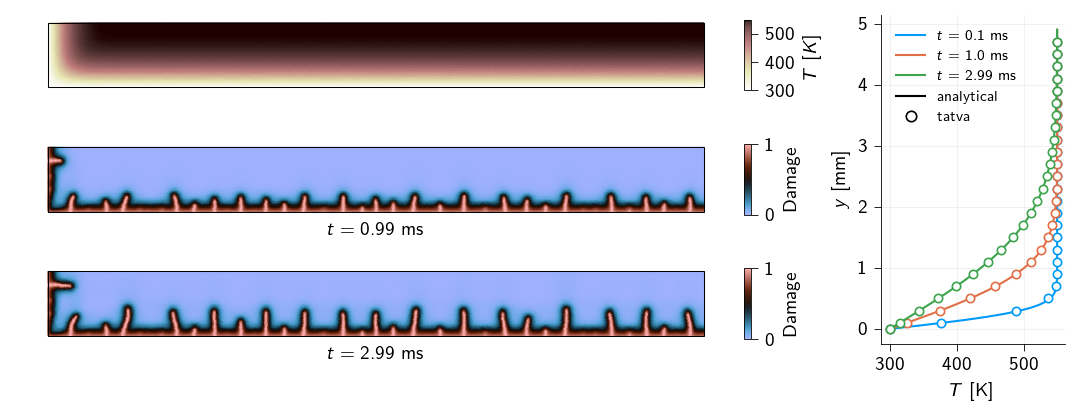

In [ ]:
# [collapse: code] Visualization of temperature, damage, and comparison with analytical solution

from matplotlib.lines import Line2D

triang = tri_mat.Triangulation(mesh.coords[:, 0], mesh.coords[:, 1], mesh.elements)


fig = plt.figure(layout="constrained", figsize=set_size(height_ratio=0.25, subplots=(3, 2)))

gs = GridSpec(
    3,
    2,
    figure=fig,
    width_ratios=[1, 0.25],
    height_ratios=[1, 1, 1],
    wspace=0.15,
    hspace=0.05,
)

new_coords = mesh.coords.copy()
new_coords[:, 0] = mesh.coords[:, 1]
new_coords[:, 1] = mesh.coords[:, 0]

step_to_plot = 299

width = x_max - x_min
height = y_max - y_min


def add_bounding_box(ax):
    rect = patches.Rectangle(
        (x_min, y_min),
        width,
        height,
        linewidth=0.5,
        edgecolor="black",
        facecolor="none",
    )
    ax.add_patch(rect)


def add_zoom_box(ax):
    rect = patches.Rectangle(
        (0, 0), 1, 1, lw=0.7, ec="black", fc="none", transform=ax.transAxes
    )
    ax.add_patch(rect)


ax1 = fig.add_subplot(gs[0, 0])
cb = ax1.tripcolor(
    triang,
    results_T[step_to_plot].flatten(),
    alpha=0.95,
    cmap="pink_r",
    shading="gouraud",
)
cb.set_clim(jnp.min(results_T[step_to_plot]), jnp.max(results_T[step_to_plot]))
cax = make_axes_locatable(ax1).append_axes("right", size="1%", pad=0.05)
fig.colorbar(cb, cax=cax, label=r"$T~[K]$")
add_bounding_box(ax1)  # <--- Add Box
ax1.set_aspect("equal")
ax1.axis("off")

ax2 = fig.add_subplot(gs[1, 0])
cb = ax2.tripcolor(
    triang,
    results_d[step_to_plot - 190],
    alpha=0.95,
    cmap="berlin",
    shading="gouraud",
    vmin=0.0,
    vmax=1.0,
)
cax = make_axes_locatable(ax2).append_axes("right", size="1%", pad=0.05)
fig.colorbar(cb, cax=cax, label=r"$\mathsf{Damage}$")
add_bounding_box(ax2)
ax2.text(
    0.5,
    -0.1,
    r"$t={:.2f}~\mathsf{{ms}}$".format(dt * (step_to_plot - 200) * 1000),
    #rf"$t=${dt * (step_to_plot - 200) * 1000}~" + r"$\mathsf{ms}$",
    transform=ax2.transAxes,
    ha="center",
    va="top",
)


ax2.set_aspect("equal")
ax2.axis("off")


ax3 = fig.add_subplot(gs[2, 0])
u_reshaped = results_u[step_to_plot].reshape(-1, 2)
grad_u = op.grad(u_reshaped)
theta_quad = op.eval(results_T[step_to_plot])
delta_theta = theta_quad - theta_quad_ref
damage_quad = op.eval(results_d[step_to_plot])

psi_plus_current, psi_minus_current = compute_elastic_energy_density(
    grad_u, delta_theta, mu, lmbda, mat.alpha
)
psi_plus_degraded = degradation_function(damage_quad) * psi_plus_current


cb = ax3.tripcolor(
    triang,
    results_d[step_to_plot],
    alpha=0.95,
    cmap="berlin",
    shading="gouraud",
    vmin=0.0,
    vmax=1.0,
)
cax = make_axes_locatable(ax3).append_axes("right", size="1%", pad=0.05)
fig.colorbar(cb, cax=cax, label=r"$\mathsf{Damage}$")

ax3.text(
    0.5,
    -0.1,
    r"$t={:.2f}~\mathsf{{ms}}$".format(dt * step_to_plot * 1000.),
    transform=ax3.transAxes,
    ha="center",
    va="top",
)


add_bounding_box(ax3)
ax3.set_aspect("equal")
ax3.axis("off")


L = y_max - y_min  # Length of domain (e.g., meters)
theta_0 = 550.0  # Initial temp of the bar (e.g., Celsius)
theta_A = 300.0  # Boundary temp at x=0 (Fixed per Eq A.2)

x_values = np.linspace(0, L, 100)  # 100 spatial points from 0 to L


prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

ax4 = fig.add_subplot(gs[:, -1])

for index, i in enumerate(np.array([10, 100, 299])):
    # Compute solution for this time step
    t = dt * i
    temp_profile = compute_temperature(x_values, t, L, mat.kappa, theta_0, theta_A)

    # Plotting
    label_str = f"$t$ = {t * 1000}~" + r"$\mathsf{ms}$" if t > 0 else "t = 0 s (Initial)"
    ax4.plot(temp_profile, x_values, label=label_str, color=colors[index])
    ax4.plot(
        results_T[i][right_nodes].flatten(),
        mesh.coords[right_nodes, 1].flatten() - y_min,
        "o",
        markeredgecolor=colors[index],
        markerfacecolor="white",
        markeredgewidth=0.8,
        markevery=2
    )

ax4.set_xlabel(r"$T~[\mathsf{K}]$")
ax4.set_ylabel(r"$y~[\mathsf{mm}]$")
ax4.grid(True)
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)
#ax4.legend(frameon=False)

legend = ax4.legend(frameon=False, numpoints=1, markerscale=1.25)
legend_elements = [
        Line2D([0], [0], color="k", linestyle="solid", label="analytical"),
        Line2D([0], [0], color="k", linestyle="none", marker="o", markeredgewidth=0.8,  markerfacecolor="white", markeredgecolor='k', label="tatva"),
    ]
legend = ax4.legend(handles=[*legend.legend_handles, *legend_elements], frameon=False, numpoints=1, markerscale=1.25)



plt.show()